In [17]:
import gym
import numpy as np
import sys
import time
import pandas as pd
import matplotlib
from collections import defaultdict, namedtuple

%matplotlib inline
matplotlib.style.use('ggplot')

In [4]:
env = gym.make("CartPole-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [20]:
class QLearning():
    def __init__(self, env, num_episodes, discount=1.0, alpha=0.5, epsilon=0.1, n_bins=10):
        self.nA = env.action_space.n
        self.nS = env.observation_space.shape[0]
        self.env = env
        self.num_episodes = num_episodes
        self.discount = discount
        self.alpha = alpha
        self.epsilon = epsilon
        # Initialize Q(s; a)
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        
        # Keeps track of useful statistics
        record = namedtuple("Record", ["episode_lengths","episode_rewards"])
        self.rec = record(episode_lengths=np.zeros(num_episodes),
                          episode_rewards=np.zeros(num_episodes))
    
        self.cart_position_bins = pd.cut([-2.4, 2.4], bins=n_bins, retbins=True)[1]
        self.pole_angle_bins = pd.cut([-2, 2], bins=n_bins, retbins=True)[1]
        self.cart_velocity_bins = pd.cut([-1, 1], bins=n_bins, retbins=True)[1]
        self.angle_rate_bins = pd.cut([-3.5, 3.5], bins=n_bins, retbins=True)[1]
        
    def __get_bins_states(self, state):
        """
        Case number of the sate is huge so in order to simplify the situation 
        cut the state sapece in to bins.
        
        if the state_idx is [1,3,6,4] than the return will be 1364
        """
        s1_, s2_, s3_, s4_ = state
        cart_position_idx = np.digitize(s1_, self.cart_position_bins)
        pole_angle_idx = np.digitize(s2_, self.pole_angle_bins)
        cart_velocity_idx = np.digitize(s3_, self.cart_velocity_bins)
        angle_rate_idx = np.digitize(s4_, self.angle_rate_bins)
        
        state_ = [cart_position_idx, pole_angle_idx, 
                  cart_velocity_idx, angle_rate_idx]
        
        state = map(lambda s: int(s), state_)
        return tuple(state)
        
    def __epislon_greedy_policy(self, epsilon, nA):

        def policy(state):
            A = np.ones(nA, dtype=float) * epsilon / nA
            best_action = np.argmax(self.Q[state])
            A[best_action] += (1.0 - epsilon)
            return A

        return policy

    def __next_action(self, prob):
        return np.random.choice(np.arange(len(prob)), p=prob)

    def qlearning(self):
        """
        q-learning algo
        """
        policy = self.__epislon_greedy_policy(self.epsilon, self.nA)
        sumlist = []

        for i_episode in range(self.num_episodes):
            # Print out which episode we are on
            if 0 == (i_episode+1) % 10:
                print("\r Episode {} in {}".format(i_episode+1, self.num_episodes))
                # sys.stdout.flush()

            step = 0
            # Initialize S
            state__ = self.env.reset()
            state = self.__get_bins_states(state__)
            
            # Repeat (for each step of episode)
            while(True):
                # Choose A from S using policy derived from Q
                prob_actions = policy(state)
                action = self.__next_action(prob_actions)
                
                # Take action A, observe R, S'
                next_state__, reward, done, info = env.step(action)
                next_state = self.__get_bins_states(next_state__)
                
                # update history record
                self.rec.episode_lengths[i_episode] += reward
                self.rec.episode_rewards[i_episode] = step
                
                # TD update: Q(S; A)<-Q(S; A) + aplha*[R + discount * max Q(S'; a) − Q(S; A)]
                best_next_action = np.argmax(self.Q[next_state])
                td_target = reward + self.discount * self.Q[next_state][best_next_action]
                td_delta = td_target - self.Q[state][action]
                self.Q[state][action] += self.alpha * td_delta

                if done:
                    # until S is terminal
                    print("Episode finished after {} timesteps".format(step))
                    sumlist.append(step)
                    break
                else:
                    step += 1
                    # S<-S'
                    state = next_state
                    
        iter_time = sum(sumlist)/len(sumlist)
        print("CartPole game iter average time is: {}".format(iter_time))
        return self.Q

cls_qlearning = QLearning(env, num_episodes=200)
Q = cls_qlearning.qlearning()

Episode finished after 9 timesteps
Episode finished after 32 timesteps
Episode finished after 11 timesteps
Episode finished after 12 timesteps
Episode finished after 8 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 21 timesteps
Episode finished after 14 timesteps
 Episode 10 in 10000
Episode finished after 22 timesteps
Episode finished after 15 timesteps
Episode finished after 9 timesteps
Episode finished after 19 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 11 timesteps
Episode finished after 17 timesteps
Episode finished after 15 timesteps
Episode finished after 16 timesteps
 Episode 20 in 10000
Episode finished after 61 timesteps
Episode finished after 39 timesteps
Episode finished after 10 timesteps
Episode finished after 92 timesteps
Episode finished after 64 timesteps
Episode finished after 74 timesteps
Episode finished after 60 timesteps
Episode finished after 62 ti

Episode finished after 85 timesteps
Episode finished after 52 timesteps
Episode finished after 27 timesteps
 Episode 220 in 10000
Episode finished after 31 timesteps
Episode finished after 78 timesteps
Episode finished after 60 timesteps
Episode finished after 25 timesteps
Episode finished after 36 timesteps
Episode finished after 56 timesteps
Episode finished after 64 timesteps
Episode finished after 23 timesteps
Episode finished after 117 timesteps
Episode finished after 47 timesteps
 Episode 230 in 10000
Episode finished after 188 timesteps
Episode finished after 29 timesteps
Episode finished after 49 timesteps
Episode finished after 26 timesteps
Episode finished after 36 timesteps
Episode finished after 43 timesteps
Episode finished after 199 timesteps
Episode finished after 151 timesteps
Episode finished after 24 timesteps
Episode finished after 66 timesteps
 Episode 240 in 10000
Episode finished after 48 timesteps
Episode finished after 12 timesteps
Episode finished after 47 time

Episode finished after 104 timesteps
Episode finished after 64 timesteps
Episode finished after 33 timesteps
Episode finished after 43 timesteps
Episode finished after 104 timesteps
 Episode 440 in 10000
Episode finished after 97 timesteps
Episode finished after 97 timesteps
Episode finished after 59 timesteps
Episode finished after 62 timesteps
Episode finished after 62 timesteps
Episode finished after 108 timesteps
Episode finished after 9 timesteps
Episode finished after 54 timesteps
Episode finished after 37 timesteps
Episode finished after 174 timesteps
 Episode 450 in 10000
Episode finished after 79 timesteps
Episode finished after 112 timesteps
Episode finished after 46 timesteps
Episode finished after 20 timesteps
Episode finished after 19 timesteps
Episode finished after 22 timesteps
Episode finished after 20 timesteps
Episode finished after 25 timesteps
Episode finished after 32 timesteps
Episode finished after 88 timesteps
 Episode 460 in 10000
Episode finished after 58 time

Episode finished after 142 timesteps
Episode finished after 199 timesteps
Episode finished after 22 timesteps
Episode finished after 15 timesteps
Episode finished after 31 timesteps
Episode finished after 136 timesteps
Episode finished after 41 timesteps
Episode finished after 122 timesteps
Episode finished after 44 timesteps
 Episode 660 in 10000
Episode finished after 44 timesteps
Episode finished after 13 timesteps
Episode finished after 23 timesteps
Episode finished after 17 timesteps
Episode finished after 21 timesteps
Episode finished after 53 timesteps
Episode finished after 18 timesteps
Episode finished after 32 timesteps
Episode finished after 12 timesteps
Episode finished after 199 timesteps
 Episode 670 in 10000
Episode finished after 88 timesteps
Episode finished after 75 timesteps
Episode finished after 62 timesteps
Episode finished after 59 timesteps
Episode finished after 35 timesteps
Episode finished after 163 timesteps
Episode finished after 190 timesteps
Episode finis

Episode finished after 199 timesteps
Episode finished after 15 timesteps
Episode finished after 10 timesteps
Episode finished after 87 timesteps
Episode finished after 90 timesteps
Episode finished after 42 timesteps
Episode finished after 19 timesteps
Episode finished after 93 timesteps
Episode finished after 25 timesteps
Episode finished after 10 timesteps
 Episode 1090 in 10000
Episode finished after 52 timesteps
Episode finished after 97 timesteps
Episode finished after 52 timesteps
Episode finished after 12 timesteps
Episode finished after 33 timesteps
Episode finished after 21 timesteps
Episode finished after 20 timesteps
Episode finished after 34 timesteps
Episode finished after 53 timesteps
Episode finished after 22 timesteps
 Episode 1100 in 10000
Episode finished after 161 timesteps
Episode finished after 94 timesteps
Episode finished after 76 timesteps
Episode finished after 66 timesteps
Episode finished after 103 timesteps
Episode finished after 186 timesteps
Episode finish

Episode finished after 44 timesteps
Episode finished after 113 timesteps
Episode finished after 97 timesteps
 Episode 1300 in 10000
Episode finished after 40 timesteps
Episode finished after 28 timesteps
Episode finished after 163 timesteps
Episode finished after 101 timesteps
Episode finished after 76 timesteps
Episode finished after 15 timesteps
Episode finished after 79 timesteps
Episode finished after 12 timesteps
Episode finished after 55 timesteps
Episode finished after 52 timesteps
 Episode 1310 in 10000
Episode finished after 54 timesteps
Episode finished after 199 timesteps
Episode finished after 58 timesteps
Episode finished after 54 timesteps
Episode finished after 95 timesteps
Episode finished after 133 timesteps
Episode finished after 184 timesteps
Episode finished after 60 timesteps
Episode finished after 22 timesteps
Episode finished after 173 timesteps
 Episode 1320 in 10000
Episode finished after 124 timesteps
Episode finished after 49 timesteps
Episode finished after 

Episode finished after 76 timesteps
Episode finished after 24 timesteps
Episode finished after 38 timesteps
Episode finished after 102 timesteps
Episode finished after 58 timesteps
Episode finished after 43 timesteps
Episode finished after 72 timesteps
Episode finished after 56 timesteps
Episode finished after 110 timesteps
 Episode 1520 in 10000
Episode finished after 160 timesteps
Episode finished after 155 timesteps
Episode finished after 188 timesteps
Episode finished after 145 timesteps
Episode finished after 41 timesteps
Episode finished after 199 timesteps
Episode finished after 76 timesteps
Episode finished after 169 timesteps
Episode finished after 199 timesteps
Episode finished after 78 timesteps
 Episode 1530 in 10000
Episode finished after 77 timesteps
Episode finished after 42 timesteps
Episode finished after 138 timesteps
Episode finished after 65 timesteps
Episode finished after 79 timesteps
Episode finished after 42 timesteps
Episode finished after 148 timesteps
Episode

Episode finished after 80 timesteps
Episode finished after 78 timesteps
Episode finished after 101 timesteps
Episode finished after 149 timesteps
Episode finished after 118 timesteps
Episode finished after 199 timesteps
Episode finished after 199 timesteps
 Episode 1740 in 10000
Episode finished after 100 timesteps
Episode finished after 199 timesteps
Episode finished after 157 timesteps
Episode finished after 70 timesteps
Episode finished after 24 timesteps
Episode finished after 117 timesteps
Episode finished after 83 timesteps
Episode finished after 50 timesteps
Episode finished after 58 timesteps
Episode finished after 10 timesteps
 Episode 1750 in 10000
Episode finished after 34 timesteps
Episode finished after 41 timesteps
Episode finished after 166 timesteps
Episode finished after 41 timesteps
Episode finished after 198 timesteps
Episode finished after 129 timesteps
Episode finished after 152 timesteps
Episode finished after 53 timesteps
Episode finished after 160 timesteps
Epis

Episode finished after 25 timesteps
Episode finished after 199 timesteps
Episode finished after 32 timesteps
Episode finished after 32 timesteps
Episode finished after 199 timesteps
Episode finished after 100 timesteps
Episode finished after 116 timesteps
Episode finished after 12 timesteps
Episode finished after 56 timesteps
 Episode 1960 in 10000
Episode finished after 79 timesteps
Episode finished after 133 timesteps
Episode finished after 143 timesteps
Episode finished after 22 timesteps
Episode finished after 27 timesteps
Episode finished after 38 timesteps
Episode finished after 55 timesteps
Episode finished after 76 timesteps
Episode finished after 9 timesteps
Episode finished after 86 timesteps
 Episode 1970 in 10000
Episode finished after 199 timesteps
Episode finished after 46 timesteps
Episode finished after 22 timesteps
Episode finished after 74 timesteps
Episode finished after 119 timesteps
Episode finished after 36 timesteps
Episode finished after 82 timesteps
Episode fin

Episode finished after 45 timesteps
Episode finished after 177 timesteps
 Episode 2170 in 10000
Episode finished after 51 timesteps
Episode finished after 51 timesteps
Episode finished after 67 timesteps
Episode finished after 92 timesteps
Episode finished after 29 timesteps
Episode finished after 104 timesteps
Episode finished after 12 timesteps
Episode finished after 10 timesteps
Episode finished after 101 timesteps
Episode finished after 10 timesteps
 Episode 2180 in 10000
Episode finished after 15 timesteps
Episode finished after 55 timesteps
Episode finished after 62 timesteps
Episode finished after 62 timesteps
Episode finished after 48 timesteps
Episode finished after 127 timesteps
Episode finished after 199 timesteps
Episode finished after 139 timesteps
Episode finished after 103 timesteps
Episode finished after 36 timesteps
 Episode 2190 in 10000
Episode finished after 53 timesteps
Episode finished after 55 timesteps
Episode finished after 15 timesteps
Episode finished after 1

Episode finished after 156 timesteps
Episode finished after 40 timesteps
Episode finished after 76 timesteps
Episode finished after 28 timesteps
Episode finished after 37 timesteps
Episode finished after 8 timesteps
Episode finished after 70 timesteps
 Episode 2390 in 10000
Episode finished after 126 timesteps
Episode finished after 98 timesteps
Episode finished after 88 timesteps
Episode finished after 42 timesteps
Episode finished after 23 timesteps
Episode finished after 63 timesteps
Episode finished after 138 timesteps
Episode finished after 199 timesteps
Episode finished after 175 timesteps
Episode finished after 170 timesteps
 Episode 2400 in 10000
Episode finished after 127 timesteps
Episode finished after 163 timesteps
Episode finished after 17 timesteps
Episode finished after 19 timesteps
Episode finished after 62 timesteps
Episode finished after 72 timesteps
Episode finished after 36 timesteps
Episode finished after 19 timesteps
Episode finished after 185 timesteps
Episode fi

Episode finished after 132 timesteps
Episode finished after 40 timesteps
Episode finished after 73 timesteps
Episode finished after 125 timesteps
 Episode 2610 in 10000
Episode finished after 13 timesteps
Episode finished after 42 timesteps
Episode finished after 12 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 43 timesteps
Episode finished after 24 timesteps
Episode finished after 78 timesteps
Episode finished after 18 timesteps
Episode finished after 54 timesteps
 Episode 2620 in 10000
Episode finished after 83 timesteps
Episode finished after 58 timesteps
Episode finished after 39 timesteps
Episode finished after 66 timesteps
Episode finished after 80 timesteps
Episode finished after 88 timesteps
Episode finished after 32 timesteps
Episode finished after 35 timesteps
Episode finished after 188 timesteps
Episode finished after 28 timesteps
 Episode 2630 in 10000
Episode finished after 93 timesteps
Episode finished after 64 ti

Episode finished after 184 timesteps
Episode finished after 121 timesteps
Episode finished after 72 timesteps
Episode finished after 134 timesteps
Episode finished after 28 timesteps
Episode finished after 33 timesteps
Episode finished after 8 timesteps
Episode finished after 47 timesteps
Episode finished after 93 timesteps
 Episode 2840 in 10000
Episode finished after 50 timesteps
Episode finished after 38 timesteps
Episode finished after 120 timesteps
Episode finished after 42 timesteps
Episode finished after 17 timesteps
Episode finished after 31 timesteps
Episode finished after 78 timesteps
Episode finished after 107 timesteps
Episode finished after 60 timesteps
Episode finished after 199 timesteps
 Episode 2850 in 10000
Episode finished after 105 timesteps
Episode finished after 49 timesteps
Episode finished after 74 timesteps
Episode finished after 77 timesteps
Episode finished after 94 timesteps
Episode finished after 32 timesteps
Episode finished after 100 timesteps
Episode fin

Episode finished after 51 timesteps
Episode finished after 41 timesteps
Episode finished after 48 timesteps
Episode finished after 100 timesteps
Episode finished after 43 timesteps
 Episode 3060 in 10000
Episode finished after 50 timesteps
Episode finished after 37 timesteps
Episode finished after 17 timesteps
Episode finished after 70 timesteps
Episode finished after 42 timesteps
Episode finished after 198 timesteps
Episode finished after 68 timesteps
Episode finished after 49 timesteps
Episode finished after 53 timesteps
Episode finished after 36 timesteps
 Episode 3070 in 10000
Episode finished after 135 timesteps
Episode finished after 128 timesteps
Episode finished after 15 timesteps
Episode finished after 36 timesteps
Episode finished after 199 timesteps
Episode finished after 94 timesteps
Episode finished after 30 timesteps
Episode finished after 160 timesteps
Episode finished after 24 timesteps
Episode finished after 169 timesteps
 Episode 3080 in 10000
Episode finished after 4

Episode finished after 15 timesteps
Episode finished after 16 timesteps
 Episode 3270 in 10000
Episode finished after 57 timesteps
Episode finished after 58 timesteps
Episode finished after 149 timesteps
Episode finished after 199 timesteps
Episode finished after 9 timesteps
Episode finished after 18 timesteps
Episode finished after 14 timesteps
Episode finished after 86 timesteps
Episode finished after 78 timesteps
Episode finished after 44 timesteps
 Episode 3280 in 10000
Episode finished after 114 timesteps
Episode finished after 199 timesteps
Episode finished after 197 timesteps
Episode finished after 85 timesteps
Episode finished after 16 timesteps
Episode finished after 74 timesteps
Episode finished after 118 timesteps
Episode finished after 149 timesteps
Episode finished after 90 timesteps
Episode finished after 199 timesteps
 Episode 3290 in 10000
Episode finished after 156 timesteps
Episode finished after 121 timesteps
Episode finished after 199 timesteps
Episode finished afte

Episode finished after 199 timesteps
Episode finished after 122 timesteps
Episode finished after 26 timesteps
Episode finished after 69 timesteps
Episode finished after 100 timesteps
Episode finished after 41 timesteps
Episode finished after 92 timesteps
Episode finished after 36 timesteps
 Episode 3500 in 10000
Episode finished after 199 timesteps
Episode finished after 75 timesteps
Episode finished after 60 timesteps
Episode finished after 199 timesteps
Episode finished after 116 timesteps
Episode finished after 142 timesteps
Episode finished after 132 timesteps
Episode finished after 69 timesteps
Episode finished after 36 timesteps
Episode finished after 39 timesteps
 Episode 3510 in 10000
Episode finished after 103 timesteps
Episode finished after 11 timesteps
Episode finished after 59 timesteps
Episode finished after 198 timesteps
Episode finished after 17 timesteps
Episode finished after 16 timesteps
Episode finished after 27 timesteps
Episode finished after 199 timesteps
Episode

Episode finished after 28 timesteps
Episode finished after 54 timesteps
 Episode 3710 in 10000
Episode finished after 41 timesteps
Episode finished after 40 timesteps
Episode finished after 15 timesteps
Episode finished after 117 timesteps
Episode finished after 151 timesteps
Episode finished after 76 timesteps
Episode finished after 18 timesteps
Episode finished after 40 timesteps
Episode finished after 31 timesteps
Episode finished after 44 timesteps
 Episode 3720 in 10000
Episode finished after 32 timesteps
Episode finished after 34 timesteps
Episode finished after 61 timesteps
Episode finished after 52 timesteps
Episode finished after 199 timesteps
Episode finished after 41 timesteps
Episode finished after 144 timesteps
Episode finished after 36 timesteps
Episode finished after 70 timesteps
Episode finished after 34 timesteps
 Episode 3730 in 10000
Episode finished after 58 timesteps
Episode finished after 199 timesteps
Episode finished after 191 timesteps
Episode finished after 44

Episode finished after 64 timesteps
Episode finished after 106 timesteps
Episode finished after 12 timesteps
Episode finished after 15 timesteps
Episode finished after 22 timesteps
Episode finished after 18 timesteps
Episode finished after 56 timesteps
Episode finished after 108 timesteps
Episode finished after 33 timesteps
 Episode 3930 in 10000
Episode finished after 125 timesteps
Episode finished after 24 timesteps
Episode finished after 79 timesteps
Episode finished after 47 timesteps
Episode finished after 168 timesteps
Episode finished after 108 timesteps
Episode finished after 31 timesteps
Episode finished after 64 timesteps
Episode finished after 83 timesteps
Episode finished after 63 timesteps
 Episode 3940 in 10000
Episode finished after 130 timesteps
Episode finished after 30 timesteps
Episode finished after 33 timesteps
Episode finished after 157 timesteps
Episode finished after 41 timesteps
Episode finished after 190 timesteps
Episode finished after 45 timesteps
Episode fi

Episode finished after 199 timesteps
Episode finished after 85 timesteps
Episode finished after 58 timesteps
Episode finished after 117 timesteps
Episode finished after 100 timesteps
Episode finished after 55 timesteps
Episode finished after 75 timesteps
Episode finished after 37 timesteps
 Episode 4150 in 10000
Episode finished after 172 timesteps
Episode finished after 65 timesteps
Episode finished after 77 timesteps
Episode finished after 65 timesteps
Episode finished after 53 timesteps
Episode finished after 61 timesteps
Episode finished after 86 timesteps
Episode finished after 20 timesteps
Episode finished after 47 timesteps
Episode finished after 59 timesteps
 Episode 4160 in 10000
Episode finished after 104 timesteps
Episode finished after 90 timesteps
Episode finished after 58 timesteps
Episode finished after 45 timesteps
Episode finished after 43 timesteps
Episode finished after 58 timesteps
Episode finished after 98 timesteps
Episode finished after 135 timesteps
Episode fini

Episode finished after 145 timesteps
Episode finished after 199 timesteps
Episode finished after 58 timesteps
Episode finished after 77 timesteps
Episode finished after 179 timesteps
Episode finished after 93 timesteps
Episode finished after 20 timesteps
Episode finished after 16 timesteps
Episode finished after 15 timesteps
Episode finished after 56 timesteps
 Episode 4370 in 10000
Episode finished after 70 timesteps
Episode finished after 60 timesteps
Episode finished after 23 timesteps
Episode finished after 39 timesteps
Episode finished after 84 timesteps
Episode finished after 189 timesteps
Episode finished after 40 timesteps
Episode finished after 62 timesteps
Episode finished after 112 timesteps
Episode finished after 26 timesteps
 Episode 4380 in 10000
Episode finished after 129 timesteps
Episode finished after 82 timesteps
Episode finished after 68 timesteps
Episode finished after 44 timesteps
Episode finished after 69 timesteps
Episode finished after 145 timesteps
Episode fin

Episode finished after 71 timesteps
Episode finished after 21 timesteps
Episode finished after 116 timesteps
Episode finished after 78 timesteps
Episode finished after 192 timesteps
Episode finished after 148 timesteps
Episode finished after 199 timesteps
 Episode 4590 in 10000
Episode finished after 104 timesteps
Episode finished after 107 timesteps
Episode finished after 28 timesteps
Episode finished after 108 timesteps
Episode finished after 28 timesteps
Episode finished after 148 timesteps
Episode finished after 40 timesteps
Episode finished after 199 timesteps
Episode finished after 41 timesteps
Episode finished after 199 timesteps
 Episode 4600 in 10000
Episode finished after 78 timesteps
Episode finished after 147 timesteps
Episode finished after 159 timesteps
Episode finished after 35 timesteps
Episode finished after 32 timesteps
Episode finished after 34 timesteps
Episode finished after 42 timesteps
Episode finished after 64 timesteps
Episode finished after 67 timesteps
Episod

Episode finished after 63 timesteps
Episode finished after 18 timesteps
Episode finished after 41 timesteps
Episode finished after 37 timesteps
Episode finished after 21 timesteps
Episode finished after 24 timesteps
Episode finished after 30 timesteps
Episode finished after 46 timesteps
Episode finished after 15 timesteps
Episode finished after 24 timesteps
 Episode 4810 in 10000
Episode finished after 79 timesteps
Episode finished after 111 timesteps
Episode finished after 41 timesteps
Episode finished after 31 timesteps
Episode finished after 82 timesteps
Episode finished after 69 timesteps
Episode finished after 41 timesteps
Episode finished after 21 timesteps
Episode finished after 34 timesteps
Episode finished after 198 timesteps
 Episode 4820 in 10000
Episode finished after 50 timesteps
Episode finished after 199 timesteps
Episode finished after 50 timesteps
Episode finished after 42 timesteps
Episode finished after 17 timesteps
Episode finished after 53 timesteps
Episode finishe

Episode finished after 53 timesteps
Episode finished after 21 timesteps
Episode finished after 66 timesteps
Episode finished after 11 timesteps
Episode finished after 55 timesteps
Episode finished after 38 timesteps
 Episode 5020 in 10000
Episode finished after 10 timesteps
Episode finished after 23 timesteps
Episode finished after 140 timesteps
Episode finished after 11 timesteps
Episode finished after 37 timesteps
Episode finished after 20 timesteps
Episode finished after 64 timesteps
Episode finished after 41 timesteps
Episode finished after 72 timesteps
Episode finished after 29 timesteps
 Episode 5030 in 10000
Episode finished after 33 timesteps
Episode finished after 36 timesteps
Episode finished after 72 timesteps
Episode finished after 39 timesteps
Episode finished after 72 timesteps
Episode finished after 84 timesteps
Episode finished after 59 timesteps
Episode finished after 105 timesteps
Episode finished after 56 timesteps
Episode finished after 36 timesteps
 Episode 5040 in

Episode finished after 24 timesteps
 Episode 5240 in 10000
Episode finished after 55 timesteps
Episode finished after 57 timesteps
Episode finished after 29 timesteps
Episode finished after 34 timesteps
Episode finished after 22 timesteps
Episode finished after 103 timesteps
Episode finished after 17 timesteps
Episode finished after 16 timesteps
Episode finished after 114 timesteps
Episode finished after 99 timesteps
 Episode 5250 in 10000
Episode finished after 147 timesteps
Episode finished after 35 timesteps
Episode finished after 17 timesteps
Episode finished after 104 timesteps
Episode finished after 33 timesteps
Episode finished after 13 timesteps
Episode finished after 22 timesteps
Episode finished after 14 timesteps
Episode finished after 30 timesteps
Episode finished after 11 timesteps
 Episode 5260 in 10000
Episode finished after 30 timesteps
Episode finished after 75 timesteps
Episode finished after 101 timesteps
Episode finished after 82 timesteps
Episode finished after 14 

Episode finished after 112 timesteps
Episode finished after 32 timesteps
Episode finished after 111 timesteps
Episode finished after 184 timesteps
Episode finished after 59 timesteps
Episode finished after 33 timesteps
Episode finished after 26 timesteps
Episode finished after 151 timesteps
 Episode 5460 in 10000
Episode finished after 27 timesteps
Episode finished after 41 timesteps
Episode finished after 15 timesteps
Episode finished after 48 timesteps
Episode finished after 14 timesteps
Episode finished after 27 timesteps
Episode finished after 20 timesteps
Episode finished after 89 timesteps
Episode finished after 27 timesteps
Episode finished after 15 timesteps
 Episode 5470 in 10000
Episode finished after 45 timesteps
Episode finished after 26 timesteps
Episode finished after 20 timesteps
Episode finished after 20 timesteps
Episode finished after 29 timesteps
Episode finished after 20 timesteps
Episode finished after 113 timesteps
Episode finished after 152 timesteps
Episode fini

Episode finished after 60 timesteps
Episode finished after 73 timesteps
Episode finished after 82 timesteps
Episode finished after 50 timesteps
 Episode 5670 in 10000
Episode finished after 69 timesteps
Episode finished after 151 timesteps
Episode finished after 23 timesteps
Episode finished after 32 timesteps
Episode finished after 127 timesteps
Episode finished after 62 timesteps
Episode finished after 66 timesteps
Episode finished after 85 timesteps
Episode finished after 68 timesteps
Episode finished after 66 timesteps
 Episode 5680 in 10000
Episode finished after 28 timesteps
Episode finished after 25 timesteps
Episode finished after 21 timesteps
Episode finished after 18 timesteps
Episode finished after 9 timesteps
Episode finished after 27 timesteps
Episode finished after 55 timesteps
Episode finished after 93 timesteps
Episode finished after 57 timesteps
Episode finished after 58 timesteps
 Episode 5690 in 10000
Episode finished after 58 timesteps
Episode finished after 68 time

Episode finished after 55 timesteps
Episode finished after 42 timesteps
Episode finished after 31 timesteps
Episode finished after 108 timesteps
Episode finished after 25 timesteps
Episode finished after 45 timesteps
Episode finished after 195 timesteps
Episode finished after 133 timesteps
 Episode 5890 in 10000
Episode finished after 38 timesteps
Episode finished after 32 timesteps
Episode finished after 57 timesteps
Episode finished after 126 timesteps
Episode finished after 34 timesteps
Episode finished after 34 timesteps
Episode finished after 24 timesteps
Episode finished after 70 timesteps
Episode finished after 47 timesteps
Episode finished after 191 timesteps
 Episode 5900 in 10000
Episode finished after 43 timesteps
Episode finished after 20 timesteps
Episode finished after 42 timesteps
Episode finished after 49 timesteps
Episode finished after 56 timesteps
Episode finished after 47 timesteps
Episode finished after 199 timesteps
Episode finished after 134 timesteps
Episode fin

Episode finished after 160 timesteps
Episode finished after 74 timesteps
 Episode 6100 in 10000
Episode finished after 38 timesteps
Episode finished after 100 timesteps
Episode finished after 27 timesteps
Episode finished after 132 timesteps
Episode finished after 127 timesteps
Episode finished after 199 timesteps
Episode finished after 199 timesteps
Episode finished after 81 timesteps
Episode finished after 68 timesteps
Episode finished after 143 timesteps
 Episode 6110 in 10000
Episode finished after 64 timesteps
Episode finished after 55 timesteps
Episode finished after 32 timesteps
Episode finished after 103 timesteps
Episode finished after 132 timesteps
Episode finished after 65 timesteps
Episode finished after 119 timesteps
Episode finished after 31 timesteps
Episode finished after 17 timesteps
Episode finished after 79 timesteps
 Episode 6120 in 10000
Episode finished after 62 timesteps
Episode finished after 199 timesteps
Episode finished after 100 timesteps
Episode finished af

Episode finished after 78 timesteps
Episode finished after 21 timesteps
Episode finished after 58 timesteps
Episode finished after 83 timesteps
Episode finished after 59 timesteps
Episode finished after 72 timesteps
Episode finished after 134 timesteps
Episode finished after 104 timesteps
Episode finished after 105 timesteps
 Episode 6320 in 10000
Episode finished after 105 timesteps
Episode finished after 94 timesteps
Episode finished after 41 timesteps
Episode finished after 74 timesteps
Episode finished after 67 timesteps
Episode finished after 48 timesteps
Episode finished after 12 timesteps
Episode finished after 13 timesteps
Episode finished after 16 timesteps
Episode finished after 48 timesteps
 Episode 6330 in 10000
Episode finished after 12 timesteps
Episode finished after 38 timesteps
Episode finished after 52 timesteps
Episode finished after 52 timesteps
Episode finished after 138 timesteps
Episode finished after 45 timesteps
Episode finished after 69 timesteps
Episode finis

Episode finished after 62 timesteps
Episode finished after 72 timesteps
Episode finished after 55 timesteps
Episode finished after 42 timesteps
Episode finished after 30 timesteps
Episode finished after 33 timesteps
Episode finished after 50 timesteps
Episode finished after 138 timesteps
 Episode 6550 in 10000
Episode finished after 101 timesteps
Episode finished after 111 timesteps
Episode finished after 129 timesteps
Episode finished after 65 timesteps
Episode finished after 99 timesteps
Episode finished after 43 timesteps
Episode finished after 103 timesteps
Episode finished after 28 timesteps
Episode finished after 14 timesteps
Episode finished after 49 timesteps
 Episode 6560 in 10000
Episode finished after 171 timesteps
Episode finished after 82 timesteps
Episode finished after 128 timesteps
Episode finished after 70 timesteps
Episode finished after 61 timesteps
Episode finished after 70 timesteps
Episode finished after 18 timesteps
Episode finished after 64 timesteps
Episode fin

Episode finished after 157 timesteps
Episode finished after 199 timesteps
Episode finished after 156 timesteps
Episode finished after 23 timesteps
 Episode 6760 in 10000
Episode finished after 21 timesteps
Episode finished after 14 timesteps
Episode finished after 45 timesteps
Episode finished after 42 timesteps
Episode finished after 101 timesteps
Episode finished after 130 timesteps
Episode finished after 17 timesteps
Episode finished after 62 timesteps
Episode finished after 45 timesteps
Episode finished after 31 timesteps
 Episode 6770 in 10000
Episode finished after 20 timesteps
Episode finished after 33 timesteps
Episode finished after 17 timesteps
Episode finished after 10 timesteps
Episode finished after 108 timesteps
Episode finished after 14 timesteps
Episode finished after 15 timesteps
Episode finished after 71 timesteps
Episode finished after 41 timesteps
Episode finished after 15 timesteps
 Episode 6780 in 10000
Episode finished after 58 timesteps
Episode finished after 62

Episode finished after 21 timesteps
 Episode 6970 in 10000
Episode finished after 199 timesteps
Episode finished after 56 timesteps
Episode finished after 78 timesteps
Episode finished after 185 timesteps
Episode finished after 46 timesteps
Episode finished after 30 timesteps
Episode finished after 161 timesteps
Episode finished after 114 timesteps
Episode finished after 15 timesteps
Episode finished after 71 timesteps
 Episode 6980 in 10000
Episode finished after 41 timesteps
Episode finished after 51 timesteps
Episode finished after 75 timesteps
Episode finished after 87 timesteps
Episode finished after 47 timesteps
Episode finished after 70 timesteps
Episode finished after 29 timesteps
Episode finished after 42 timesteps
Episode finished after 32 timesteps
Episode finished after 87 timesteps
 Episode 6990 in 10000
Episode finished after 199 timesteps
Episode finished after 95 timesteps
Episode finished after 65 timesteps
Episode finished after 43 timesteps
Episode finished after 183

Episode finished after 98 timesteps
 Episode 7190 in 10000
Episode finished after 46 timesteps
Episode finished after 12 timesteps
Episode finished after 13 timesteps
Episode finished after 46 timesteps
Episode finished after 61 timesteps
Episode finished after 22 timesteps
Episode finished after 14 timesteps
Episode finished after 9 timesteps
Episode finished after 98 timesteps
Episode finished after 96 timesteps
 Episode 7200 in 10000
Episode finished after 72 timesteps
Episode finished after 81 timesteps
Episode finished after 54 timesteps
Episode finished after 155 timesteps
Episode finished after 120 timesteps
Episode finished after 195 timesteps
Episode finished after 199 timesteps
Episode finished after 81 timesteps
Episode finished after 13 timesteps
Episode finished after 43 timesteps
 Episode 7210 in 10000
Episode finished after 32 timesteps
Episode finished after 168 timesteps
Episode finished after 148 timesteps
Episode finished after 23 timesteps
Episode finished after 67 

Episode finished after 199 timesteps
Episode finished after 27 timesteps
Episode finished after 194 timesteps
Episode finished after 18 timesteps
Episode finished after 21 timesteps
Episode finished after 50 timesteps
Episode finished after 61 timesteps
Episode finished after 94 timesteps
 Episode 7410 in 10000
Episode finished after 99 timesteps
Episode finished after 139 timesteps
Episode finished after 140 timesteps
Episode finished after 63 timesteps
Episode finished after 20 timesteps
Episode finished after 21 timesteps
Episode finished after 42 timesteps
Episode finished after 126 timesteps
Episode finished after 148 timesteps
Episode finished after 46 timesteps
 Episode 7420 in 10000
Episode finished after 36 timesteps
Episode finished after 25 timesteps
Episode finished after 72 timesteps
Episode finished after 33 timesteps
Episode finished after 45 timesteps
Episode finished after 85 timesteps
Episode finished after 28 timesteps
Episode finished after 56 timesteps
Episode fini

Episode finished after 13 timesteps
 Episode 7630 in 10000
Episode finished after 39 timesteps
Episode finished after 22 timesteps
Episode finished after 23 timesteps
Episode finished after 85 timesteps
Episode finished after 33 timesteps
Episode finished after 199 timesteps
Episode finished after 37 timesteps
Episode finished after 95 timesteps
Episode finished after 15 timesteps
Episode finished after 49 timesteps
 Episode 7640 in 10000
Episode finished after 146 timesteps
Episode finished after 27 timesteps
Episode finished after 161 timesteps
Episode finished after 34 timesteps
Episode finished after 22 timesteps
Episode finished after 18 timesteps
Episode finished after 51 timesteps
Episode finished after 28 timesteps
Episode finished after 37 timesteps
Episode finished after 134 timesteps
 Episode 7650 in 10000
Episode finished after 113 timesteps
Episode finished after 172 timesteps
Episode finished after 37 timesteps
Episode finished after 35 timesteps
Episode finished after 90

Episode finished after 153 timesteps
Episode finished after 72 timesteps
Episode finished after 48 timesteps
Episode finished after 122 timesteps
Episode finished after 142 timesteps
Episode finished after 47 timesteps
 Episode 7860 in 10000
Episode finished after 60 timesteps
Episode finished after 117 timesteps
Episode finished after 50 timesteps
Episode finished after 139 timesteps
Episode finished after 66 timesteps
Episode finished after 116 timesteps
Episode finished after 45 timesteps
Episode finished after 109 timesteps
Episode finished after 98 timesteps
Episode finished after 50 timesteps
 Episode 7870 in 10000
Episode finished after 78 timesteps
Episode finished after 41 timesteps
Episode finished after 114 timesteps
Episode finished after 77 timesteps
Episode finished after 46 timesteps
Episode finished after 22 timesteps
Episode finished after 76 timesteps
Episode finished after 48 timesteps
Episode finished after 105 timesteps
Episode finished after 77 timesteps
 Episode 

Episode finished after 190 timesteps
Episode finished after 43 timesteps
 Episode 8070 in 10000
Episode finished after 59 timesteps
Episode finished after 62 timesteps
Episode finished after 27 timesteps
Episode finished after 113 timesteps
Episode finished after 146 timesteps
Episode finished after 80 timesteps
Episode finished after 24 timesteps
Episode finished after 25 timesteps
Episode finished after 67 timesteps
Episode finished after 61 timesteps
 Episode 8080 in 10000
Episode finished after 19 timesteps
Episode finished after 144 timesteps
Episode finished after 28 timesteps
Episode finished after 49 timesteps
Episode finished after 199 timesteps
Episode finished after 142 timesteps
Episode finished after 171 timesteps
Episode finished after 52 timesteps
Episode finished after 120 timesteps
Episode finished after 36 timesteps
 Episode 8090 in 10000
Episode finished after 72 timesteps
Episode finished after 73 timesteps
Episode finished after 35 timesteps
Episode finished after 

Episode finished after 23 timesteps
Episode finished after 59 timesteps
Episode finished after 46 timesteps
Episode finished after 32 timesteps
Episode finished after 22 timesteps
Episode finished after 122 timesteps
Episode finished after 23 timesteps
Episode finished after 21 timesteps
 Episode 8300 in 10000
Episode finished after 11 timesteps
Episode finished after 44 timesteps
Episode finished after 27 timesteps
Episode finished after 24 timesteps
Episode finished after 25 timesteps
Episode finished after 13 timesteps
Episode finished after 37 timesteps
Episode finished after 42 timesteps
Episode finished after 30 timesteps
Episode finished after 44 timesteps
 Episode 8310 in 10000
Episode finished after 199 timesteps
Episode finished after 24 timesteps
Episode finished after 169 timesteps
Episode finished after 60 timesteps
Episode finished after 130 timesteps
Episode finished after 33 timesteps
Episode finished after 44 timesteps
Episode finished after 151 timesteps
Episode finis

Episode finished after 51 timesteps
Episode finished after 21 timesteps
 Episode 8520 in 10000
Episode finished after 18 timesteps
Episode finished after 34 timesteps
Episode finished after 17 timesteps
Episode finished after 172 timesteps
Episode finished after 23 timesteps
Episode finished after 45 timesteps
Episode finished after 42 timesteps
Episode finished after 13 timesteps
Episode finished after 12 timesteps
Episode finished after 20 timesteps
 Episode 8530 in 10000
Episode finished after 11 timesteps
Episode finished after 17 timesteps
Episode finished after 111 timesteps
Episode finished after 12 timesteps
Episode finished after 97 timesteps
Episode finished after 107 timesteps
Episode finished after 65 timesteps
Episode finished after 143 timesteps
Episode finished after 127 timesteps
Episode finished after 16 timesteps
 Episode 8540 in 10000
Episode finished after 18 timesteps
Episode finished after 121 timesteps
Episode finished after 73 timesteps
Episode finished after 62

Episode finished after 45 timesteps
Episode finished after 36 timesteps
Episode finished after 13 timesteps
Episode finished after 31 timesteps
Episode finished after 59 timesteps
Episode finished after 19 timesteps
 Episode 8740 in 10000
Episode finished after 107 timesteps
Episode finished after 76 timesteps
Episode finished after 43 timesteps
Episode finished after 17 timesteps
Episode finished after 32 timesteps
Episode finished after 90 timesteps
Episode finished after 102 timesteps
Episode finished after 67 timesteps
Episode finished after 54 timesteps
Episode finished after 29 timesteps
 Episode 8750 in 10000
Episode finished after 124 timesteps
Episode finished after 92 timesteps
Episode finished after 69 timesteps
Episode finished after 196 timesteps
Episode finished after 20 timesteps
Episode finished after 25 timesteps
Episode finished after 42 timesteps
Episode finished after 156 timesteps
Episode finished after 71 timesteps
Episode finished after 102 timesteps
 Episode 876

Episode finished after 56 timesteps
Episode finished after 13 timesteps
Episode finished after 30 timesteps
Episode finished after 37 timesteps
Episode finished after 68 timesteps
Episode finished after 60 timesteps
Episode finished after 12 timesteps
Episode finished after 159 timesteps
Episode finished after 199 timesteps
Episode finished after 91 timesteps
 Episode 8960 in 10000
Episode finished after 199 timesteps
Episode finished after 71 timesteps
Episode finished after 15 timesteps
Episode finished after 130 timesteps
Episode finished after 31 timesteps
Episode finished after 184 timesteps
Episode finished after 13 timesteps
Episode finished after 112 timesteps
Episode finished after 50 timesteps
Episode finished after 38 timesteps
 Episode 8970 in 10000
Episode finished after 81 timesteps
Episode finished after 35 timesteps
Episode finished after 199 timesteps
Episode finished after 16 timesteps
Episode finished after 18 timesteps
Episode finished after 14 timesteps
Episode fin

Episode finished after 30 timesteps
Episode finished after 99 timesteps
Episode finished after 128 timesteps
Episode finished after 27 timesteps
 Episode 9170 in 10000
Episode finished after 113 timesteps
Episode finished after 49 timesteps
Episode finished after 29 timesteps
Episode finished after 79 timesteps
Episode finished after 22 timesteps
Episode finished after 30 timesteps
Episode finished after 34 timesteps
Episode finished after 15 timesteps
Episode finished after 15 timesteps
Episode finished after 80 timesteps
 Episode 9180 in 10000
Episode finished after 59 timesteps
Episode finished after 175 timesteps
Episode finished after 169 timesteps
Episode finished after 68 timesteps
Episode finished after 36 timesteps
Episode finished after 37 timesteps
Episode finished after 103 timesteps
Episode finished after 23 timesteps
Episode finished after 65 timesteps
Episode finished after 60 timesteps
 Episode 9190 in 10000
Episode finished after 161 timesteps
Episode finished after 32

Episode finished after 158 timesteps
Episode finished after 138 timesteps
Episode finished after 199 timesteps
Episode finished after 141 timesteps
Episode finished after 122 timesteps
 Episode 9400 in 10000
Episode finished after 26 timesteps
Episode finished after 72 timesteps
Episode finished after 27 timesteps
Episode finished after 60 timesteps
Episode finished after 25 timesteps
Episode finished after 104 timesteps
Episode finished after 74 timesteps
Episode finished after 29 timesteps
Episode finished after 148 timesteps
Episode finished after 29 timesteps
 Episode 9410 in 10000
Episode finished after 87 timesteps
Episode finished after 20 timesteps
Episode finished after 15 timesteps
Episode finished after 67 timesteps
Episode finished after 57 timesteps
Episode finished after 194 timesteps
Episode finished after 38 timesteps
Episode finished after 52 timesteps
Episode finished after 89 timesteps
Episode finished after 72 timesteps
 Episode 9420 in 10000
Episode finished after 

Episode finished after 32 timesteps
 Episode 9620 in 10000
Episode finished after 32 timesteps
Episode finished after 48 timesteps
Episode finished after 42 timesteps
Episode finished after 196 timesteps
Episode finished after 45 timesteps
Episode finished after 43 timesteps
Episode finished after 88 timesteps
Episode finished after 152 timesteps
Episode finished after 186 timesteps
Episode finished after 67 timesteps
 Episode 9630 in 10000
Episode finished after 100 timesteps
Episode finished after 123 timesteps
Episode finished after 146 timesteps
Episode finished after 27 timesteps
Episode finished after 94 timesteps
Episode finished after 71 timesteps
Episode finished after 19 timesteps
Episode finished after 199 timesteps
Episode finished after 89 timesteps
Episode finished after 30 timesteps
 Episode 9640 in 10000
Episode finished after 73 timesteps
Episode finished after 82 timesteps
Episode finished after 130 timesteps
Episode finished after 96 timesteps
Episode finished after 

Episode finished after 199 timesteps
Episode finished after 35 timesteps
Episode finished after 56 timesteps
Episode finished after 19 timesteps
Episode finished after 109 timesteps
Episode finished after 99 timesteps
 Episode 9840 in 10000
Episode finished after 66 timesteps
Episode finished after 21 timesteps
Episode finished after 115 timesteps
Episode finished after 12 timesteps
Episode finished after 52 timesteps
Episode finished after 40 timesteps
Episode finished after 67 timesteps
Episode finished after 15 timesteps
Episode finished after 14 timesteps
Episode finished after 15 timesteps
 Episode 9850 in 10000
Episode finished after 56 timesteps
Episode finished after 68 timesteps
Episode finished after 19 timesteps
Episode finished after 20 timesteps
Episode finished after 51 timesteps
Episode finished after 35 timesteps
Episode finished after 15 timesteps
Episode finished after 15 timesteps
Episode finished after 82 timesteps
Episode finished after 45 timesteps
 Episode 9860 i

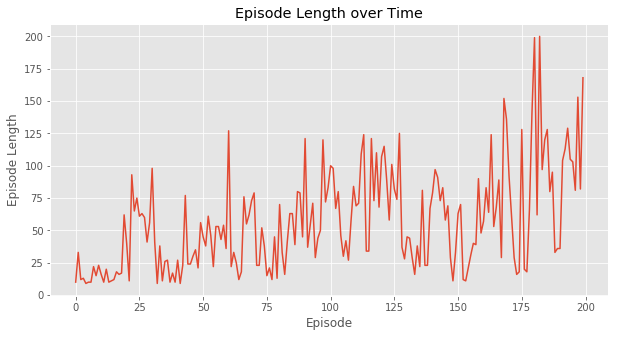

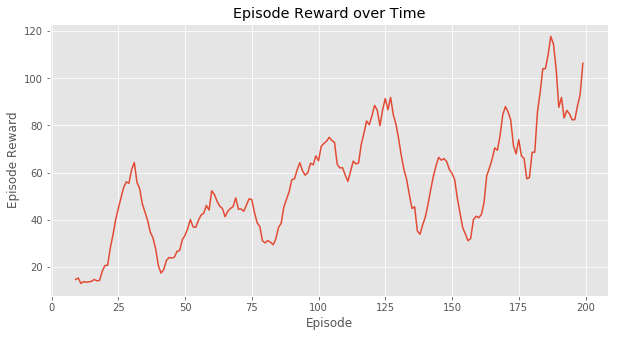

(<matplotlib.figure.Figure at 0x16fd1d30>,
 <matplotlib.figure.Figure at 0x17051fd0>)

In [27]:
from matplotlib import pyplot as plt

def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths[:200])
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards[:200]).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward")
    plt.title("Episode Reward over Time".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    return fig1, fig2

plot_episode_stats(cls_qlearning.rec)